# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import wandb
from wandb.integration.lightgbm import wandb_callback, log_summary as lgb_log_summary
from wandb.integration.catboost import WandbCallback, log_summary as cat_log_summary
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings('ignore')

import func.features as ft

# WandB 설정

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: audrs56 (recsys008-naver-boostcamp). Use `wandb login --relogin` to force relogin


True

## 올바른 팀에 올리는지 확인!

In [3]:
print(wandb.api.default_entity)

recsys008-naver-boostcamp


# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
path = "../../../data/"  # 알잘딱 수정
train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

#추가
interest = pd.read_csv(path + 'interestRate.csv')
park = pd.read_csv(path + 'parkInfo.csv')
school = pd.read_csv(path + 'schoolinfo.csv')
subway = pd.read_csv(path + 'subwayInfo.csv')


## 중복 값 확인 및 처리

In [6]:
duplicates = train_data[train_data.drop(columns=['index']).duplicated(keep=False)]
duplicates

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
15,15,84.9342,201907,31,2,7,2016,36.965423,127.048779,3,18000.0
16,16,84.9342,201907,31,2,7,2016,36.965423,127.048779,3,18000.0
28,28,146.4005,201911,21,2,5,2016,36.965423,127.048779,3,37000.0
29,29,146.4005,201911,21,2,5,2016,36.965423,127.048779,3,37000.0
33,33,84.9342,201912,14,2,14,2016,36.965423,127.048779,3,19000.0
...,...,...,...,...,...,...,...,...,...,...,...
1801197,1801197,101.9088,202308,22,2,11,2010,37.528394,126.659398,13,33000.0
1801198,1801198,114.9285,202308,28,1,18,2010,37.528394,126.659398,13,30000.0
1801199,1801199,114.9285,202308,28,1,18,2010,37.528394,126.659398,13,30000.0
1801210,1801210,114.9285,202310,26,2,9,2010,37.528394,126.659398,13,39000.0


In [4]:
# 중복 제거 (첫 번째 발생 유지)
train_data = train_data.drop_duplicates(subset=train_data.columns.drop('index'), keep='first')
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0


# 금리 데이터 추가

In [5]:
interest['contract_year_month'] = interest['year_month']
train_data = pd.merge(train_data, interest[['contract_year_month', 'interest_rate']], on='contract_year_month', how='left')
test_data = pd.merge(test_data, interest[['contract_year_month', 'interest_rate']],on='contract_year_month',how='left')

# 가장 가까운 지하철 거리 추가

In [6]:
# 지하철 역 데이터의 경위도 배열 생성
subway_coords = subway[['latitude', 'longitude']].to_numpy()

# 아파트 데이터 경위도 배열 생성
apart_coords_train = train_data[['latitude', 'longitude']].to_numpy()
apart_coords_test = test_data[['latitude', 'longitude']].to_numpy()

# 각 아파트에 대해 가까운 지하철역 거리 추가
train_data.loc[:, 'nearest_subway_distance'] = ft.calculate_nearest_subway_distance(apart_coords_train, subway_coords)
test_data.loc[:, 'nearest_subway_distance'] = ft.calculate_nearest_subway_distance(apart_coords_test, subway_coords)

# 학교 레벨별로 가장 가까운 학교 추가

In [7]:
# 각 아파트에 대해 가까운 학교 거리 추가
nearest_school_distances = ft.calculate_nearest_school_distance(apart_coords_train, school)
for level in nearest_school_distances:
    train_data[f'nearest_{level}_distance'] = nearest_school_distances[level]

nearest_school_distances = ft.calculate_nearest_school_distance(apart_coords_test, school)
for level in nearest_school_distances:
    test_data[f'nearest_{level}_distance'] = nearest_school_distances[level]

# 가장 가까운 공원 거리 추가

In [8]:
# 공원 데이터 경위도 배열 생성
park_coords = park[['latitude', 'longitude']].to_numpy()

# 각 아파트에 대해 가장 가까운 공원까지의 거리 계산
train_data['nearest_park_distance'] = ft.calculate_nearest_park_distance(apart_coords_train, park_coords)

test_data['nearest_park_distance'] = ft.calculate_nearest_park_distance(apart_coords_test, park_coords)

# 가장 가까운 공원 면적 추가

In [9]:
# 공원 면적 0인 것들 제거
park = park[park['area'] > 0]

# 공원 면적 데이터
park_areas = park['area'].to_numpy()

# 각 아파트에 대해 가장 가까운 공원의 면적 추가
train_data['nearest_park_area'] =ft.nearest_park_area(apart_coords_train, park_coords, park_areas)

test_data['nearest_park_area'] = ft.nearest_park_area(apart_coords_test, park_coords, park_areas)


# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [10]:
# 전체 재학습 데이터를 따로 빼놓음
all_data = train_data.copy()

holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [11]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
# 전체 재학습 추가 부분
X_all = all_data.drop(columns=['deposit'])
y_all = all_data['deposit']
X_test = test_data.copy()

# 'cluster' 피처 추가
* 필요에 따라 DBSCAN/KMeans 중 선택해서 사용

### DBSCAN 클러스터링 
* 경도, 위도 스케일링 후 DBSCAN으로 train 기반하여 클러스터 생성
* holdout(=validation)은 경도,위도 기준 가장 가까운 train 샘플의 라벨을 할당

In [15]:
# # 데이터 스케일링
# scaler = StandardScaler()

# X_train_location = X_train[['latitude', 'longitude']].copy()
# X_holdout_location = X_holdout[['latitude', 'longitude']].copy()

# X_train_location_scaled = scaler.fit_transform(X_train_location)
# X_holdout_location_scaled = scaler.transform(X_holdout_location)

# # 2. Train 데이터에 DBSCAN 적용
# dbscan = DBSCAN(eps=0.02, min_samples=15)  # 파라미터는 데이터에 맞게 조정 필요
# train_clusters = dbscan.fit_predict(X_train_location_scaled)

# # 3. Validation 데이터에 클러스터 라벨 할당
# nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
# nn.fit(X_train_location_scaled)  # train의 경도, 위도로 NN을 피팅

# distances, indices = nn.kneighbors(X_holdout_location_scaled)  # holdout 샘플 당, 가장 근처의 train 샘플을 찾음
# holdout_clusters = train_clusters[indices.flatten()]  # 가장 가까운 train 샘플의 클러스터 라벨을 상속받음

# # 4. 클러스터 정보를 포함한 데이터셋 생성
# X_train['cluster'] = train_clusters
# X_holdout['cluster'] = holdout_clusters

### K-Means 클러스터링 
* 경도, 위도 스케일링 후 K-Means train 기반하여 클러스터 생성
* holdout(=validation)은 경도,위도 기준 가장 가까운 train 샘플의 라벨을 할당

In [12]:
# 데이터 스케일링
scaler = StandardScaler()

X_train_location = X_train[['latitude', 'longitude']].copy()
X_holdout_location = X_holdout[['latitude', 'longitude']].copy()
X_test_location = X_test[['latitude', 'longitude']].copy()

X_train_location_scaled = scaler.fit_transform(X_train_location)
X_holdout_location_scaled = scaler.transform(X_holdout_location)
X_test_location_scaled = scaler.transform(X_test_location)

# K-Means 적용 (클러스터 수는 데이터에 맞게 조정)
kmeans = KMeans(n_clusters=25, random_state= RANDOM_SEED)

train_clusters = kmeans.fit_predict(X_train_location_scaled)
holdout_clusters = kmeans.predict(X_holdout_location_scaled)
test_clusters = kmeans.predict(X_test_location_scaled)

# 클러스터 정보를 포함한 데이터셋 생성
X_train['cluster'] = train_clusters
X_holdout['cluster'] = holdout_clusters
X_test['cluster'] = test_clusters

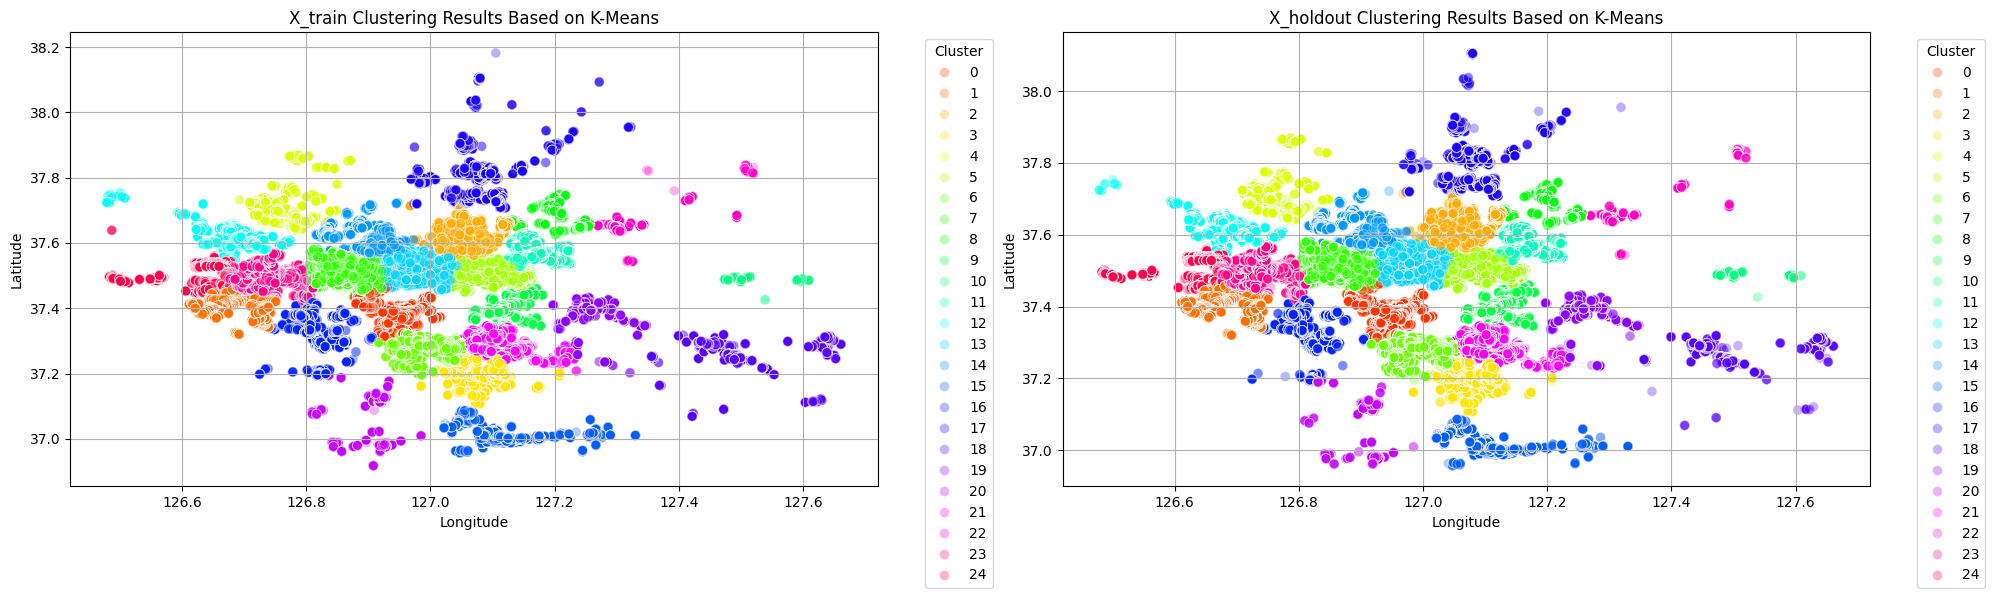

In [20]:
# 데이터셋과 제목을 정의
datasets = [(X_train, 'X_train Clustering Results Based on K-Means'), 
            (X_holdout, 'X_holdout Clustering Results Based on K-Means')]

# 전체 figure 크기
plt.figure(figsize=(20, 6))

# 반복문으로 두 개의 그래프 그리기
for i, (data, title) in enumerate(datasets, 1):
    plt.subplot(1, 2, i)  # 1행 2열 레이아웃
    sns.scatterplot(x=data['longitude'], 
                    y=data['latitude'], 
                    hue=data['cluster'],  
                    palette=sns.color_palette('hsv', 25),  
                    legend='full',
                    s=50,  
                    alpha=0.3)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

# 레이아웃이 겹치지 않도록 조정
plt.tight_layout()
plt.show()

In [17]:
X_train.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate,nearest_subway_distance,nearest_elementary_distance,nearest_middle_distance,nearest_high_distance,nearest_park_distance,nearest_park_area,cluster
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,1.78,0.857916,0.144165,0.577958,1.131958,0.359024,67862.0,15
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,1.26,0.857916,0.144165,0.577958,1.131958,0.359024,67862.0,15
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,1.26,0.857916,0.144165,0.577958,1.131958,0.359024,67862.0,15
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,1.68,3.698483,0.169996,0.819788,0.749925,0.160243,1776.1,15
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1.85,1.231527,1.032098,2.471571,2.548584,0.472096,98886.0,15


In [18]:
X_holdout.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate,nearest_subway_distance,nearest_elementary_distance,nearest_middle_distance,nearest_high_distance,nearest_park_distance,nearest_park_area,cluster
736113,774291,102.6654,202307,8,0,7,2023,37.200075,126.820401,0,3.69,8.553991,0.148796,0.539747,0.623334,0.212244,24489.3,16
736114,774292,102.9485,202307,19,0,8,2023,37.200075,126.820401,0,3.69,8.553991,0.148796,0.539747,0.623334,0.212244,24489.3,16
736115,774293,102.9485,202307,27,0,12,2023,37.200075,126.820401,0,3.69,8.553991,0.148796,0.539747,0.623334,0.212244,24489.3,16
736116,774294,94.3147,202307,30,0,4,2023,37.200075,126.820401,0,3.69,8.553991,0.148796,0.539747,0.623334,0.212244,24489.3,16
736117,774295,94.3147,202308,12,0,1,2023,37.200075,126.820401,0,3.66,8.553991,0.148796,0.539747,0.623334,0.212244,24489.3,16


# 모델 훈련

## 피처 선택

In [13]:
# 피처 선택
train_columns = ['area_m2', 'contract_year_month', 'contract_day', 'floor', 'built_year', 'latitude', 'longitude',
              'nearest_subway_distance', 'nearest_elementary_distance', 'nearest_middle_distance', 'nearest_high_distance', 'nearest_park_distance', 'nearest_park_area', 'cluster']
X_train = X_train[train_columns]
X_holdout = X_holdout[train_columns]
X_test = X_test[train_columns]

# LightGBM 모델 훈련

In [14]:
# 플롯 제목 통일을 위해 커스텀 콜백 설정
def custom_wandb_callback():
    def callback(env):
        for data_name, metric_name, value, _ in env.evaluation_result_list:
            # 메트릭 이름 변경
            if metric_name == 'l1':
                metric_name = 'MAE'
            elif metric_name == 'rmse':
                metric_name = 'RMSE'
            
            # 로그 이름 생성
            log_name = f"{data_name}-{metric_name}"
            
            # wandb에 로그 기록
            wandb.log({log_name: value}, step=env.iteration)
    return callback

# wandb 초기화
wandb.init(project="DBSCAN_Kmeans", name="clustering_kmeans", entity="recsys008-naver-boostcamp")  # 실험명에 따라 name, entity 등 변경해주기!!

# LightGBM 파라미터 설정
lgb_params = {
    'objective': 'regression',
    'metric': ['mae', 'rmse'],
    'boosting_type': 'gbdt',
    'num_leaves': 1000,  # 각 트리의 최대 리프 수
    'learning_rate': 0.05,
    'n_estimators': 1000,  # 트리를 몇 개 사용하여 부스팅할건지, epoch와 비슷함
    # 'feature_fraction': 0.6,  # 각 트리가 사용할 컬럼의 비율 eg. 0.8이면 10개의 컬럼 중 8개만 사용
    # 'bagging_fraction': 0.8,  # 각 트리가 사용할 데이터의 비율 eg. 0.8이면 80퍼센트의 데이터 샘플만 사용
    # 'bagging_freq': 5,  # 몇번째 트리마다 배깅을 적용할건지 eg. 5이면 5번째 트리마다 배깅 적용
    'verbose': -1,
    'random_state': RANDOM_SEED
}

# wandb에 파라미터 로깅
wandb.config.update(lgb_params)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_holdout, label=y_holdout, reference=train_data)

# LightGBM 모델 학습
lgb_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[valid_data],
    valid_names='validation',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        custom_wandb_callback()
    ]
)

# 특성 중요도 로깅
lgb_log_summary(lgb_model)

# Holdout 데이터 예측 - validation 데이터에 대해 가장 좋았던 iteration 사용
lgb_holdout_pred = lgb_model.predict(X_holdout, num_iteration=lgb_model.best_iteration)

# 성능 메트릭 계산
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
lgb_holdout_rmse = np.sqrt(mean_squared_error(y_holdout, lgb_holdout_pred))
lgb_holdout_r2 = r2_score(y_holdout, lgb_holdout_pred)

# wandb에 성능 지표 로깅
wandb.log({
    "holdout_mae": lgb_holdout_mae,
    "holdout_rmse": lgb_holdout_rmse,
    "holdout_r2": lgb_holdout_r2
})

# 결과 출력
print("Holdout 데이터셋 LGBM 성능:")
print(f"MAE: {lgb_holdout_mae:.2f}")
print(f"RMSE: {lgb_holdout_rmse:.2f}")
print(f"R²: {lgb_holdout_r2:.2f}")

# wandb 실험 종료
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: audrs56 (recsys008-naver-boostcamp). Use `wandb login --relogin` to force relogin


Training until validation scores don't improve for 50 rounds
[100]	validation's l1: 4942.95	validation's rmse: 8116.88
[200]	validation's l1: 4537.62	validation's rmse: 7672.87
[300]	validation's l1: 4440.11	validation's rmse: 7586.78
[400]	validation's l1: 4375.92	validation's rmse: 7547.5
[500]	validation's l1: 4349.5	validation's rmse: 7527.09
[600]	validation's l1: 4329.31	validation's rmse: 7509.89
[700]	validation's l1: 4319.53	validation's rmse: 7504.38
[800]	validation's l1: 4308.05	validation's rmse: 7497.9
Early stopping, best iteration is:
[813]	validation's l1: 4306.92	validation's rmse: 7497.23
Holdout 데이터셋 LGBM 성능:
MAE: 4306.92
RMSE: 7497.23
R²: 0.93


holdout_mae,▁
holdout_r2,▁
holdout_rmse,▁
validation-MAE,█▇▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation-RMSE,██▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,813
holdout_mae,4306.92231
holdout_r2,0.93115
holdout_rmse,7497.2313
validation-MAE,4304.95128
validation-RMSE,7498.28784


## Optuna 파라미터 서칭

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)  # optuna log 설정

def objective(trial):
    # 하이퍼 파라미터 범위 지정
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 800, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15, step=0.025),
        'n_estimators': trial.suggest_int('n_estimators', 800, 1500, step=100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200, step=20),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0, step=0.05),  # 각 트리가 사용할 데이터의 비율 eg. 0.8이면 80퍼센트의 데이터 샘플만 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 20, step=5),  # 몇번째 트리마다 배깅을 적용할건지 eg. 5이면 5번째 트리마다 배깅 적용
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0, step=0.05),  # 각 트리가 사용할 컬럼의 비율 eg. 0.8이면 10개의 컬럼 중 8개만 사용
        'metric': 'mae',
        'random_state': RANDOM_SEED,
        'verbose': 0,
    }

    # lgb model 선언 및 훈련
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_holdout, label=y_holdout, reference=train_data)

    # LightGBM 모델 학습
    lgb_model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        valid_names='validation',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # holdout에 대한 예측
    holdout_pred = lgb_model.predict(X_holdout)
    mae = mean_absolute_error(y_holdout, holdout_pred)
    return mae


# Optuna 객체 생성
study = optuna.create_study(direction='minimize')

# MAE 최적화 수행
study.optimize(objective,
               n_trials=3,  # 몇번의 서칭을 할건지
               n_jobs=-1,  # 사용할 쓰레드의 수, -1이면 최대 실제 코어 개수
)

# 최적 런과 파라미터 출력
best_params = study.best_params
print("Best parameters:", best_params)
print("Best MAE:", study.best_value)

# Catboost 모델 훈련

In [ ]:
# wandb 초기화
wandb.init(project="house_price_prediction", name="catboost_base")  # 실험명에 따라 name 변경해주기!!

# CatBoost 파라미터 설정
cat_params = {
    'iterations': 1000,
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'early_stopping_rounds': 100,
    'verbose': 100,
    'random_seed': RANDOM_SEED
}

# wandb에 파라미터 로깅
wandb.config.update(cat_params)

# CatBoost 데이터셋 생성
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_holdout, y_holdout)

# CatBoost 모델 생성
cat_model = CatBoostRegressor(**cat_params)

# 모델 학습
cat_model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    callbacks=[WandbCallback()]
)

# Holdout 데이터 예측
cat_holdout_pred = cat_model.predict(X_holdout)

# 성능 메트릭 계산
cat_holdout_mae = mean_absolute_error(y_holdout, cat_holdout_pred)
cat_holdout_rmse = np.sqrt(mean_squared_error(y_holdout, cat_holdout_pred))
cat_holdout_r2 = r2_score(y_holdout, cat_holdout_pred)

# wandb에 성능 지표 로깅
wandb.log({
    "holdout_mae": cat_holdout_mae,
    "holdout_rmse": cat_holdout_rmse,
    "holdout_r2": cat_holdout_r2
})

# 결과 출력
print("Holdout 데이터셋 CatBoost 성능:")
print(f"MAE: {cat_holdout_mae:.2f}")
print(f"RMSE: {cat_holdout_rmse:.2f}")
print(f"R²: {cat_holdout_r2:.2f}")

# 특성 중요도 로깅
feature_importance = cat_model.get_feature_importance()
feature_importance_dict = dict(zip(X_train.columns, feature_importance))
wandb.log({"feature_importance": wandb.plot.bar(wandb.Table(data=[[k, v] for k, v in feature_importance_dict.items()], columns=["feature", "importance"]), "feature", "importance", title="Feature Importance")})

# wandb 실험 종료
wandb.finish()

# Sample Submission 제출하기

### 전체 데이터로 클러스터링 다시하기(DBSCAN)

In [14]:
# 데이터 스케일링
scaler = StandardScaler()

X_all_location = X_all[['latitude', 'longitude']].copy()
X_test_location = X_test[['latitude', 'longitude']].copy()

X_all_location_scaled = scaler.fit_transform(X_all_location)
X_test_location_scaled = scaler.transform(X_test_location)

# 2. Train 데이터에 DBSCAN 적용
dbscan = DBSCAN(eps=0.02, min_samples=15)  # 파라미터는 데이터에 맞게 조정 필요
train_clusters = dbscan.fit_predict(X_all_location_scaled)

# 3. Validation 데이터에 클러스터 라벨 할당
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(X_all_location_scaled)  # train의 경도, 위도로 NN을 피팅

distances, indices = nn.kneighbors(X_test_location_scaled)  # test 샘플 당, 가장 근처의 train 샘플을 찾음
test_clusters = train_clusters[indices.flatten()]  # 가장 가까운 train 샘플의 클러스터 라벨을 상속받음

# 4. 클러스터 정보를 포함한 데이터셋 생성
X_all['cluster'] = train_clusters
X_test['cluster'] = test_clusters

### 전체 데이터로 클러스터링 다시하기(K-Means)

In [15]:
# X_all에 대한 클러스터링 추가
X_all_location = X_all[['latitude', 'longitude']].copy()
X_all_location_scaled = scaler.transform(X_all_location)

all_clusters = kmeans.predict(X_all_location_scaled)

# 클러스터 정보를 X_all에 추가
X_all['cluster'] = all_clusters

## 전체 데이터로 LGBM 재학습

In [16]:
# 피처 선택
X_all = X_all[train_columns]
X_test = X_test[train_columns]

# LightGBM 파라미터 설정
lgb_params = {
    'objective': 'regression',
    'metric': ['mae', 'rmse'],
    'boosting_type': 'gbdt',
    'num_leaves': 1000,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    # 'feature_fraction': 1.0,  # 각 트리가 사용할 컬럼의 비율 eg. 0.8이면 10개의 컬럼 중 8개만 사용
    # 'bagging_fraction': 1.0,  # 각 트리가 사용할 데이터의 비율 eg. 0.8이면 80퍼센트의 데이터 샘플만 사용
    # 'bagging_freq': 0,  # 몇번째 트리마다 배깅을 적용할건지 eg. 5이면 5번째 트리마다 배깅 적용
    'verbose': 1,
    'random_state': RANDOM_SEED
}

# LightGBM 데이터셋 생성
all_data = lgb.Dataset(X_all, label=y_all)

# LightGBM 모델 학습
lgb_model = lgb.train(
    lgb_params,
    all_data,
)

# 추론
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 1717611, number of used features: 14
[LightGBM] [Info] Start training from score 38231.334035


KeyboardInterrupt: 

## 전체 데이터로 Catboost 재학습

In [ ]:
# # 피처 선택
# X_all = X_all[train_columns]
# X_test = X_test[train_columns]

# # CatBoost 파라미터 설정
# cat_params = {
#     'iterations': 1000,
#     'loss_function': 'RMSE',
#     'eval_metric': 'MAE',
#     'verbose': 100,
#     'random_seed': RANDOM_SEED
# }

# # CatBoost 데이터셋 생성
# all_pool = Pool(X_all, y_all)
# test_pool = Pool(X_test)

# # CatBoost 모델 생성
# cat_model = CatBoostRegressor(**cat_params)

# # 모델 학습
# cat_model.fit(all_pool)

# # 추론
# cat_test_pred = cat_model.predict(test_pool)
# sample_submission['deposit'] = cat_test_pred
# sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')